**Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.**

In [70]:
import json

# Open and load the JSON file
with open("D:/Data_Science/1631809090_1481053515_ultimate_challenge_3_/ultimate_challenge/logins.json", "r") as f:
    data = json.load(f)

In [71]:
import pandas as pd

df = pd.read_json("D:/Data_Science/1631809090_1481053515_ultimate_challenge_3_/ultimate_challenge/logins.json")

df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [72]:
df.shape

(93142, 1)

In [73]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [74]:
# Convert login_time to datetime
df["login_time"] = pd.to_datetime(df["login_time"])

# Set login_time as index
df = df.set_index("login_time")

# Verify index
df.index

DatetimeIndex(['1970-01-01 20:13:18', '1970-01-01 20:16:10',
               '1970-01-01 20:16:37', '1970-01-01 20:16:36',
               '1970-01-01 20:26:21', '1970-01-01 20:21:41',
               '1970-01-01 20:12:16', '1970-01-01 20:35:47',
               '1970-01-01 20:35:38', '1970-01-01 20:47:52',
               ...
               '1970-04-13 18:36:53', '1970-04-13 18:40:31',
               '1970-04-13 18:46:06', '1970-04-13 18:40:40',
               '1970-04-13 18:48:52', '1970-04-13 18:50:19',
               '1970-04-13 18:43:56', '1970-04-13 18:54:02',
               '1970-04-13 18:57:38', '1970-04-13 18:54:23'],
              dtype='datetime64[ns]', name='login_time', length=93142, freq=None)

In [75]:
df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [76]:
# Aggregate login events into 15-minute bins
logins_15min = df.resample("15min").size()

# Preview aggregated series
logins_15min.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, dtype: int64

In [77]:
# Descriptive statistics
logins_15min.describe()

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
dtype: float64

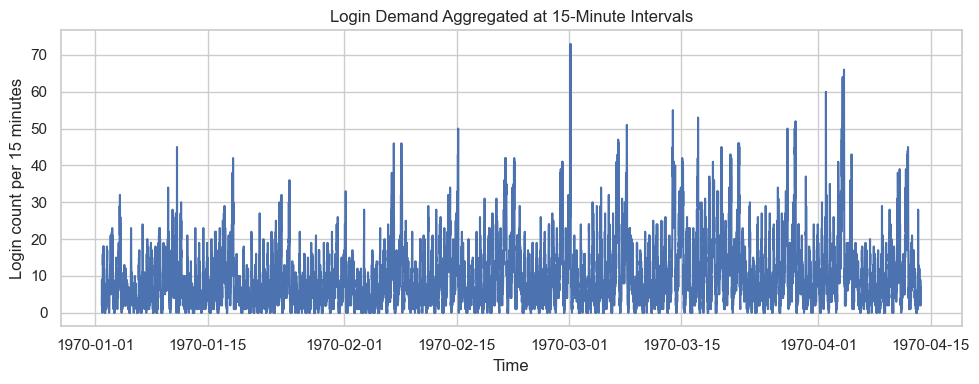

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(logins_15min)
plt.xlabel("Time")
plt.ylabel("Login count per 15 minutes")
plt.title("Login Demand Aggregated at 15-Minute Intervals")
plt.tight_layout()
plt.show()

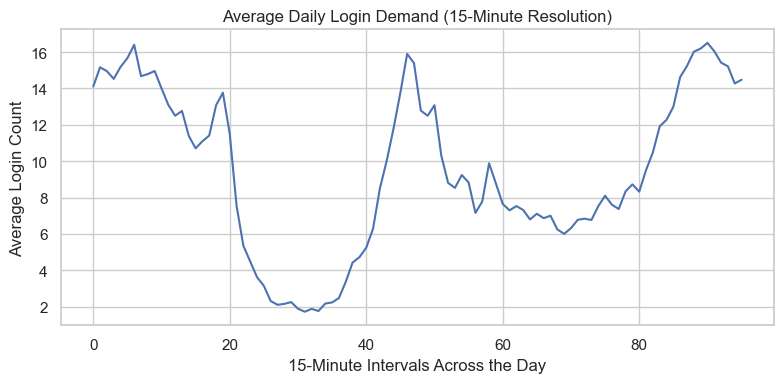

In [79]:
# Create time-of-day index
logins_by_time = logins_15min.copy()
logins_by_time.index = logins_by_time.index.time

# Compute average demand for each 15-minute time-of-day slot
daily_cycle = logins_by_time.groupby(logins_by_time.index).mean()

# Plot daily cycle
plt.figure(figsize=(8, 4))
plt.plot(daily_cycle.values)
plt.xlabel("15-Minute Intervals Across the Day")
plt.ylabel("Average Login Count")
plt.title("Average Daily Login Demand (15-Minute Resolution)")
plt.tight_layout()
plt.show()

**Part 3 ‐ Predictive modeling:
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).**

# ============================================================================
# 1. Imports & Load Data
# ============================================================================

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)

sns.set(style="whitegrid")

In [81]:
import json

# Open and load the JSON file
with open("D:/Data_Science/1631809090_1481053515_ultimate_challenge_3_/ultimate_challenge/ultimate_data_challenge.json", "r") as f:
    data = json.load(f)

In [82]:
import pandas as pd

df1 = pd.read_json("D:/Data_Science/1631809090_1481053515_ultimate_challenge_3_/ultimate_challenge/ultimate_data_challenge.json")

df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# ============================================================================
# 2. Data Cleaning & Exploratory Analysis
# ============================================================================


**2.1 Convert Dates**

In [83]:
date_cols = ["signup_date", "last_trip_date"]
for col in date_cols:
    df1[col] = pd.to_datetime(df1[col])

**2.2 Define Target Variable (Retention)**

A user is retained if they were active in the preceding 30 days.
We assume the dataset was pulled on July 1, 2014 (standard assumption in this challenge).

In [84]:
cutoff_date = pd.to_datetime("2014-07-01")

df1["retained"] = (
    (cutoff_date - df1["last_trip_date"]).dt.days <= 30
).astype(int)

df1["retained"].value_counts(normalize=True)

retained
0    0.62392
1    0.37608
Name: proportion, dtype: float64

In [102]:
retention_rate = df1["retained"].mean()
print(f"Fraction of retained users: {retention_rate:.2%}")

Fraction of retained users: 37.61%


**2.3 Handle Missing Values**

In [86]:
df1.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

Ratings → fill with median, 
Categorical → fill with mode

In [87]:
df1["avg_rating_of_driver"].fillna(df1["avg_rating_of_driver"].median(), inplace=True)
df1["avg_rating_by_driver"].fillna(df1["avg_rating_by_driver"].median(), inplace=True)
df1["phone"] = df1["phone"].fillna("Unknown")

C:\Users\User\AppData\Local\Temp\ipykernel_28068\948445962.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1["avg_rating_of_driver"].fillna(df1["avg_rating_of_driver"].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_28068\948445962.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [88]:
df1.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
retained                  0
dtype: int64

**2.4 Encode Categorical Variables**

In [89]:
df1 = pd.get_dummies(
    df1,
    columns=["city", "phone"],
    drop_first=True
)

In [90]:
df1["ultimate_black_user"] = df1["ultimate_black_user"].astype(int)

**2.5 Feature Selection**

In [91]:
df_model = df1.drop(
    columns=["signup_date", "last_trip_date"]
)

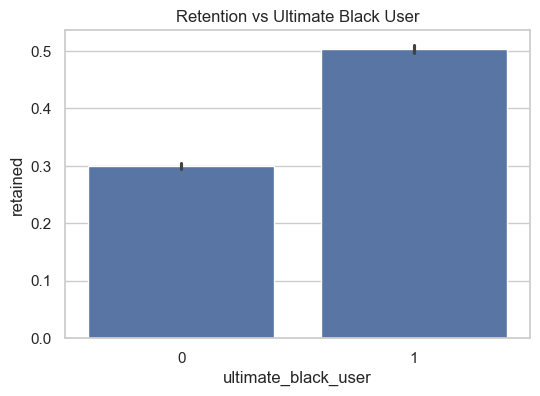

In [92]:
plt.figure(figsize=(6,4))
sns.barplot(x="ultimate_black_user", y="retained", data=df1)
plt.title("Retention vs Ultimate Black User")
plt.show()

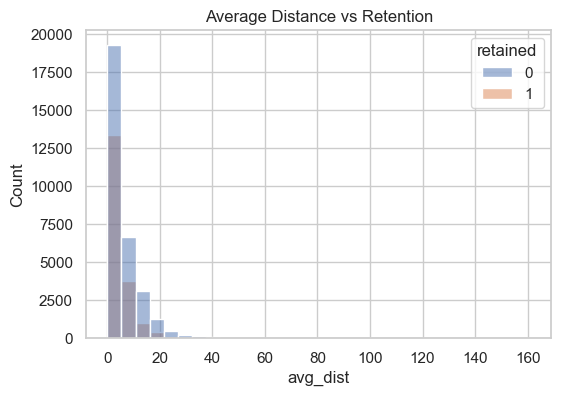

In [93]:
plt.figure(figsize=(6,4))
sns.histplot(data=df1, x="avg_dist", hue="retained", bins=30)
plt.title("Average Distance vs Retention")
plt.show()

# ============================================================================
# 3. Predictive Modelling
# ============================================================================

**3.1 Train-Test Split**

In [94]:
X = df_model.drop(columns=["retained"])
y = df_model["retained"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

**3.2 Feature Scaling**

In [95]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**3.3 Logistic Regression Model**

In [96]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

**3.4 Model Evaluation**

In [97]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7152
ROC-AUC: 0.7552396348164676

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79      7799
           1       0.66      0.49      0.57      4701

    accuracy                           0.72     12500
   macro avg       0.70      0.67      0.68     12500
weighted avg       0.71      0.72      0.70     12500



In [98]:
confusion_matrix(y_test, y_pred)

array([[6615, 1184],
       [2376, 2325]], dtype=int64)

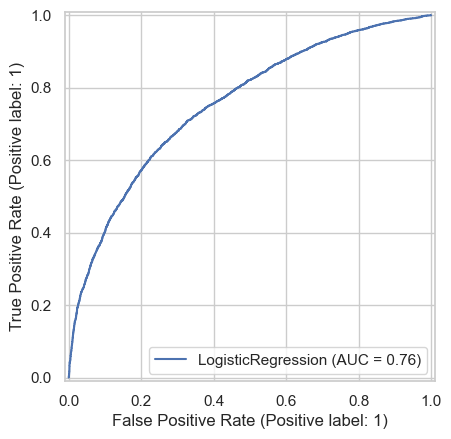

In [99]:
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.show()

**3.5 Feature Importance (Interpretability)**

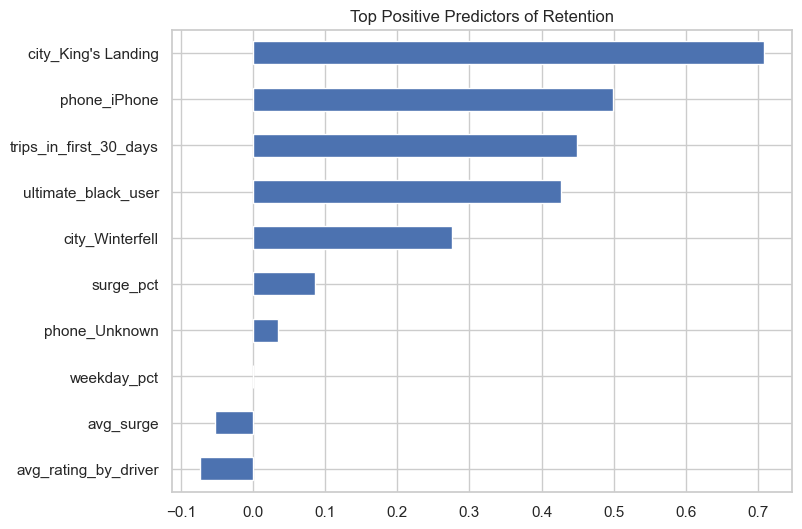

In [100]:
feature_importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values()

plt.figure(figsize=(8,6))
feature_importance.tail(10).plot(kind="barh")
plt.title("Top Positive Predictors of Retention")
plt.show()

**Key Business Insights Priority Actions: 
Geographic Expansion: Study what makes King's Landing successful and replicate in other cities 
iOS Investment: The app experience matters - ensure iOS app is optimized; investigate why Android lags 
Early Engagement: Focus on getting new users to take multiple trips in first 30 days (referral credits, onboarding campaigns) 
Premium Tier: Ultimate Black program works - consider expanding it or creating more tiers
City-Specific Strategies: Tailor retention efforts by city since location has huge impact 
Things That Don't Matter Much: 
Weekday vs weekend usage 
Average driver ratings (within normal ranges) 
Moderate surge exposure 
This model tells you where to focus resources for maximum retention impact!**